# Two Topics Coupled example

## Import Python built-in functions we need to run and plot the game

In [9]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sb

### Set up inline matplotlib

In [10]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

## Import Game Modules From a Given Path
User have to edit the path and put the correct one on his/her machine.

In [11]:
import sys
# search path for modules
sys.path.append('/Users/hn/Documents/GitHub/PyOpinionGame/')

import opiniongame.config as og_cfg
import opiniongame.IO as og_io
import opiniongame.coupling as og_coupling
import opiniongame.state as og_state
import opiniongame.adjacency as og_adj
import opiniongame.selection as og_select
import opiniongame.potentials as og_pot
import opiniongame.core as og_core
import opiniongame.stopping as og_stop
import opiniongame.opinions as og_opinions

## Setting Up Game Parameters

In [12]:
config = og_cfg.staticParameters()

path = '/Users/hn/Documents/GitHub/PyOpinionGame/'  # path to the 'staticParameters.cfg'
staticParameters = path + 'staticParameters.cfg'

config.readFromFile(staticParameters) # Read static parameters
config.threshold = 0.0001
config.Kthreshold = 0.00001
config.startingseed = 10
config.learning_rate = 0.1
tau = 0.62 #tip of the tent potential function
config.printOut()

StaticParameters:
Learning rate     = 0.1
Unique. strength  = 0.0
Skew. strength  = 0.0
NumExperiments    = 100
PopSize           = 20
Threshold         = 0.0001
Hthreshold        = 1e-06
Kthreshold        = 1e-05
ntopics           = 1
startingSeed      = 10
iterationMax      = 200



# seed PRNG: must do this before any random numbers are ever sampled during default generation

In [13]:
print("SEEDING PRNG: "+str(config.startingseed))
np.random.seed(config.startingseed)

SEEDING PRNG: 10


# Set up the state of the system
### State of the system includes:
- Weight Matrix (Matrix of the coupling wieghts between topic)
- Initial Opinions of agents
- Adjacency matrix of the network

*** This is just initialization of the state, later we update some elements of it.***

In [18]:
# These are the default matrices for the state of the system:
# If you want to change them, you can generate a new one in the following cell
default_weights = og_coupling.weights_no_coupling(config.popSize, config.ntopics)
default_initialOpinions = og_opinions.initialize_opinions(config.popSize, config.ntopics)
default_adj = og_adj.make_adj(config.popSize, 'full')

state = og_state.WorldState(adj=default_adj, 
                            couplingWeights=default_weights, 
                            initialOpinions=default_initialOpinions, 
                            initialHistorySize=100, 
                            historyGrowthScale=2)
state.validate()

WEIGHT SHAPE   : (75, 1, 1)
OPINION SHAPE  : (75, 1)
ADJACENCY SHAPE: (75, 75)
==> World state validation passed.



## User Defined States and parameters Can go in the following cell:

In [23]:
numberOfCommunities = 3
communityPopSize    = 25
config.popSize = numberOfCommunities * communityPopSize

# List of upper bound probability of interaction between communities
uppBound_list = [0.0]

# List of uniqueness Strength parameter
individStrength = [0.0]

config.learning_rate = 0.1
config.iterationMax = 10000
tau = 0.62
config.printOut()
#
# functions for use by the simulation engine
#
ufuncs = og_cfg.UserFunctions(og_select.PickTwoWeighted,
                              og_stop.iterationStop,
                              og_pot.createTent(tau))
                              

# Number of different initial opinions, 
# i.e. number of different games with different initials.
noInitials = np.arange(1)
noGames = np.arange(1)    # Number of different game orders.

StaticParameters:
Learning rate     = 0.1
Unique. strength  = 0.0
Skew. strength  = 0.0
NumExperiments    = 100
PopSize           = 75
Threshold         = 0.0001
Hthreshold        = 1e-06
Kthreshold        = 1e-05
ntopics           = 1
startingSeed      = 10
iterationMax      = 10000



In [33]:
# Run experiments with different adjacencies, different initials, and different order of games.
for uniqForce in individStrength:
    config.uniqstrength = uniqForce
    for upperBound in uppBound_list:
        # Generate different adjacency matrix with different prob. of interaction
        # between different communities
        state.adj = og_adj.CommunitiesMatrix(communityPopSize, numberOfCommunities, upperBound)
                
        for countInitials in noInitials:
            # for each adjacency, generate 100 different initial opinions
            # state.initialOpinions = og_opinions.initialize_opinions(config.popSize, config.ntopics)
         
            # Pick three communities with similar opinions to begin with!
            state.initialOpinions = np.zeros((config.popSize, 1))
            state.initialOpinions[0:25]  = np.random.uniform(low=0.0, high=.25, size=(25,1))
            state.initialOpinions[25:50] = np.random.uniform(low=0.41, high=.58, size=(25,1))
            state.initialOpinions[50:75] = np.random.uniform(low=0.74, high= 1, size=(25,1))
   
            state.couplingWeights = og_coupling.weights_no_coupling(config.popSize, config.ntopics)
            all_experiments_history = {}
            print "(uniqForce, upperBound)  = ({}, {})".format(uniqForce, upperBound)
            print "countInitials = {}".format(countInitials + 1)
            
            for gameOrders in noGames:
                #cProfile.run('og_core.run_until_convergence(config, state, ufuncs)')
                state = og_core.run_until_convergence(config, state, ufuncs)
                print("One Experiment Done" , "gameOrders = " , gameOrders+1)
                all_experiments_history[ 'experiment' + str(gameOrders+1)] = state.history[0:state.nextHistoryIndex,:,:]
            og_io.saveMatrix('uB' + str(upperBound) + '*uS' + str(config.uniqstrength) + 
                             '*initCount' + str(countInitials+21) + '.mat', all_experiments_history)

(uniqForce, upperBound)  = (0.0, 0.0)
countInitials = 1

('One Experiment Done', 'gameOrders = ', 1)


In [38]:
print all_experiments_history.keys()
print all_experiments_history['experiment1'].shape

['experiment1']
(10000, 75, 1)


# Plot the experiment done above:

In [39]:
time, population_size, no_of_topics = evolution = all_experiments_history['experiment1'].shape
evolution = all_experiments_history['experiment1'].reshape(time, population_size)

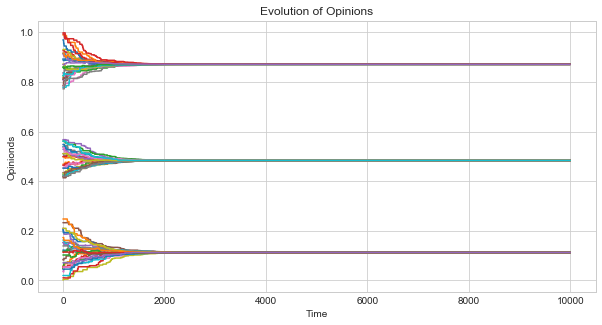

In [45]:
fig = plt.figure()
plt.plot(evolution)
plt.xlabel('Time')
plt.ylabel('Opinionds')
plt.title('Evolution of Opinions')
fig.set_size_inches(10,5)
plt.show()

# Skew Uniqueness Tendency Driver:

I observed when having tendency for uniqueness is drawn from normal distribution, we do not get an interesting result. For example, initial intuition was that uniqueness for tendency would delay stabilization of the network, however, it did not. So, here we draw uniqueness tendencies from skew normal distribution.
When most neighbors tend to go in one directions, then probability of individuals to go to the opposite direction would be more than the niose in the same direction:

In [46]:
state = og_state.WorldState(adj=default_adj, 
                            couplingWeights=default_weights, 
                            initialOpinions=default_initialOpinions, 
                            initialHistorySize=100, 
                            historyGrowthScale=2)
state.validate()

WEIGHT SHAPE   : (75, 1, 1)
OPINION SHAPE  : (75, 1)
ADJACENCY SHAPE: (75, 75)
==> World state validation passed.



In [54]:
#
# load configuration
#
config = og_cfg.staticParameters()
config.readFromFile('staticParameters.cfg')
config.threshold = 0.01
config.printOut()

StaticParameters:
Learning rate     = 0.1
Unique. strength  = 0.0
Skew. strength  = 0.0
NumExperiments    = 100
PopSize           = 20
Threshold         = 0.01
Hthreshold        = 1e-06
Kthreshold        = 2e-05
ntopics           = 1
startingSeed      = 10
iterationMax      = 200



In [55]:
#
# seed PRNG: must do this before any random numbers are
# ever sampled during default generation
#
print(("SEEDING PRNG: "+str(config.startingseed)))
np.random.seed(config.startingseed)

SEEDING PRNG: 10


## Initiate State

In [56]:
# These are the default matrices for the state of the system:
# If you want to change them, you can generate a new one in the following cell
default_weights = og_coupling.weights_no_coupling(config.popSize, config.ntopics)
default_initialOpinions = og_opinions.initialize_opinions(config.popSize, config.ntopics)
default_adj = og_adj.make_adj(config.popSize, 'full')

state = og_state.WorldState(adj=default_adj, 
                            couplingWeights=default_weights, 
                            initialOpinions=default_initialOpinions, 
                            initialHistorySize=100, 
                            historyGrowthScale=2)
state.validate()

WEIGHT SHAPE   : (20, 1, 1)
OPINION SHAPE  : (20, 1)
ADJACENCY SHAPE: (20, 20)
==> World state validation passed.



In [57]:
#
# run
#
numberOfCommunities = 3
communityPopSize    = 25
config.popSize = numberOfCommunities * communityPopSize

# List of upper bound probability of interaction between communities
uppBound_list = np.array([.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.019])
#
# List of uniqueness Strength parameter
#
individStrength = np.arange(0.00001, 0.000251, 0.00006)
individStrength = np.append(0, individStrength)
individStrength = np.array([0.0])
skewstrength = 2.0

tau = 0.62
config.iterationMax = 30000
config.printOut()

StaticParameters:
Learning rate     = 0.1
Unique. strength  = 0.0
Skew. strength  = 0.0
NumExperiments    = 100
PopSize           = 75
Threshold         = 0.01
Hthreshold        = 1e-06
Kthreshold        = 2e-05
ntopics           = 1
startingSeed      = 10
iterationMax      = 30000



In [59]:
#
# functions for use by the simulation engine
#
ufuncs = og_cfg.UserFunctions(og_select.PickTwoWeighted,
                              og_stop.iterationStop,
                              og_pot.createTent(tau))


In [60]:
                              
noInitials = np.arange(1) # Number of different initial opinions.
noGames = np.arange(1)    # Number of different game orders.
# Run experiments with different adjacencies, different initials, and different order of games.
for uniqForce in individStrength:
    config.uniqstrength = uniqForce
    for upperBound in uppBound_list:
        # Generate different adjacency matrix with different prob. of interaction
        # between different communities
        state.adj = og_adj.CommunitiesMatrix(communityPopSize, numberOfCommunities, upperBound)
        print"(upperBound, uniqForce) = (", upperBound, "," , uniqForce , ")"            
        for countInitials in noInitials:
            # for each adjacency, generate 100 different initial opinions
            # state.initialOpinions = og_opinions.initialize_opinions(config.popSize, config.ntopics)
         
            # Pick three communities with similar opinions to begin with!
            state.initialOpinions = np.zeros((config.popSize, 1))
            state.initialOpinions[0:25]  = np.random.uniform(low=0.08, high=.1, size=(25,1))
            state.initialOpinions[25:50] = np.random.uniform(low=0.49, high=.51, size=(25,1))
            state.initialOpinions[50:75] = np.random.uniform(low=0.9, high= .92, size=(25,1))
   
            state.couplingWeights = og_coupling.weights_no_coupling(config.popSize, config.ntopics)
            all_experiments_history = {}

            print "countInitials=", countInitials + 1
            
            for gameOrders in noGames:
                #cProfile.run('og_core.run_until_convergence(config, state, ufuncs)')
                state = og_core.run_until_convergence(config, state, ufuncs)
                state.history = state.history[0:state.nextHistoryIndex,:,:]
                idx_IN_columns = [i for i in xrange(np.shape(state.history)[0]) if (i % (config.popSize)) == 0]
                state.history = state.history[idx_IN_columns,:,:]
                all_experiments_history[ 'experiment' + str(gameOrders+1)] = state.history
            og_io.saveMatrix('uB' + str(upperBound) + '*uS' + str(config.uniqstrength) + 
                             '*initCount' + str(countInitials+1) + '.mat', all_experiments_history)


(upperBound, uniqForce) = ( 0.001 , 0.0 )
countInitials= 1

(upperBound, uniqForce) = ( 0.004 , 0.0 )
countInitials= 1

(upperBound, uniqForce) = ( 0.007 , 0.0 )
countInitials= 1

(upperBound, uniqForce) = ( 0.01 , 0.0 )
countInitials= 1

(upperBound, uniqForce) = ( 0.013 , 0.0 )
countInitials= 1

(upperBound, uniqForce) = ( 0.016 , 0.0 )
countInitials= 1

(upperBound, uniqForce) = ( 0.019 , 0.0 )
countInitials= 1



In [62]:
all_experiments_history.keys()

['experiment1']

In [67]:
time, population_size, no_of_topics = all_experiments_history['experiment1'].shape
evolution = all_experiments_history['experiment1'].reshape(time, population_size)

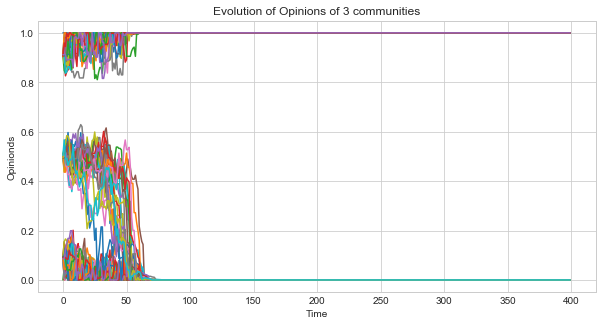

In [74]:
fig = plt.figure()
plt.plot(evolution)
plt.xlabel('Time')
plt.ylabel('Opinionds')
plt.title('Evolution of Opinions of 3 communities')
fig.set_size_inches(10,5)
plt.show()